# Impacts of stereochemistry and activity cliffs in quantitative structure-activity relationships (QSAR) models


## Activity cliffs
__Activity Cliffs__ (ACs) were generally defined as pairs of structurally similar compounds showing a marked difference in potency. The existence of ACs directly defies the intuitive idea that chemical compounds with similar structures should have similar activities, often referred to as the molecular similarity principle, and highlights the remarkable specificity of their interaction with biological systems (e.g., proteins). As such, ACs received strong attention in computational chemistry and drug design [Stumpfe et al. 2019](https://pubs.acs.org/doi/10.1021/acsomega.9b02221), [Tilborg et al. 2022](https://pubs.acs.org/doi/full/10.1021/acs.jcim.2c01073).

Activity cliff can be defined based on the substracture of molecules or the similarity computed by molecular representations.  

The figure below shows selected examples of activity cliffs from [Stumpfe et al. 2019](https://pubs.acs.org/doi/10.1021/acsomega.9b02221).

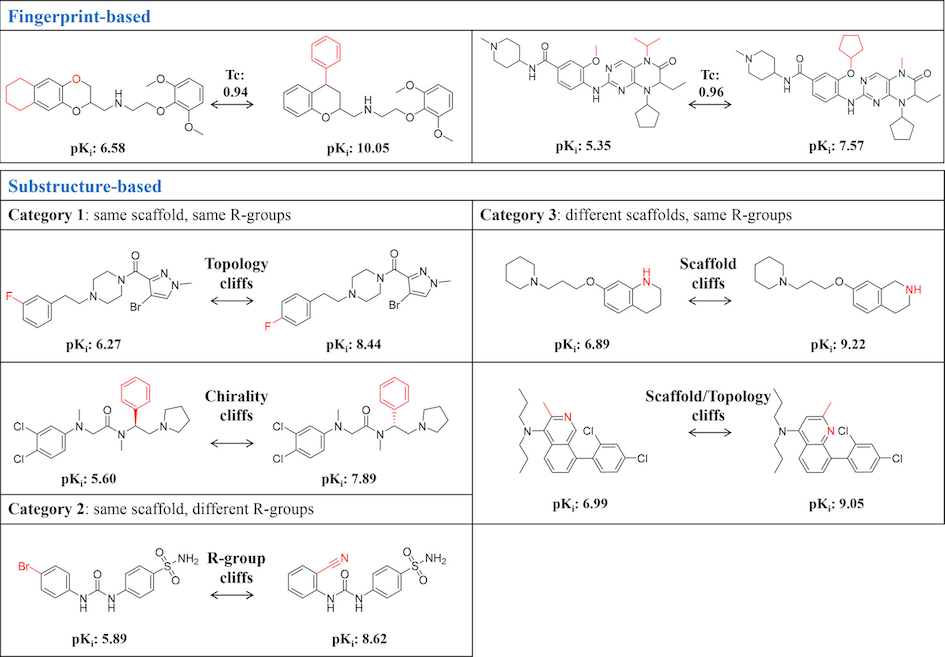

## Stereoisomerism


__Stereoisomerism__ refers to the phenomenon where molecules with the same molecular formula and connectivity (i.e., the same number and type of atoms bound in the same sequence) differ in the spatial arrangement of their atoms, leading to the existence of stereoisomers. Stereoisomers are a type of isomer where the differences arise not from the sequence of bonds but from the orientation of the atoms in three-dimensional space.
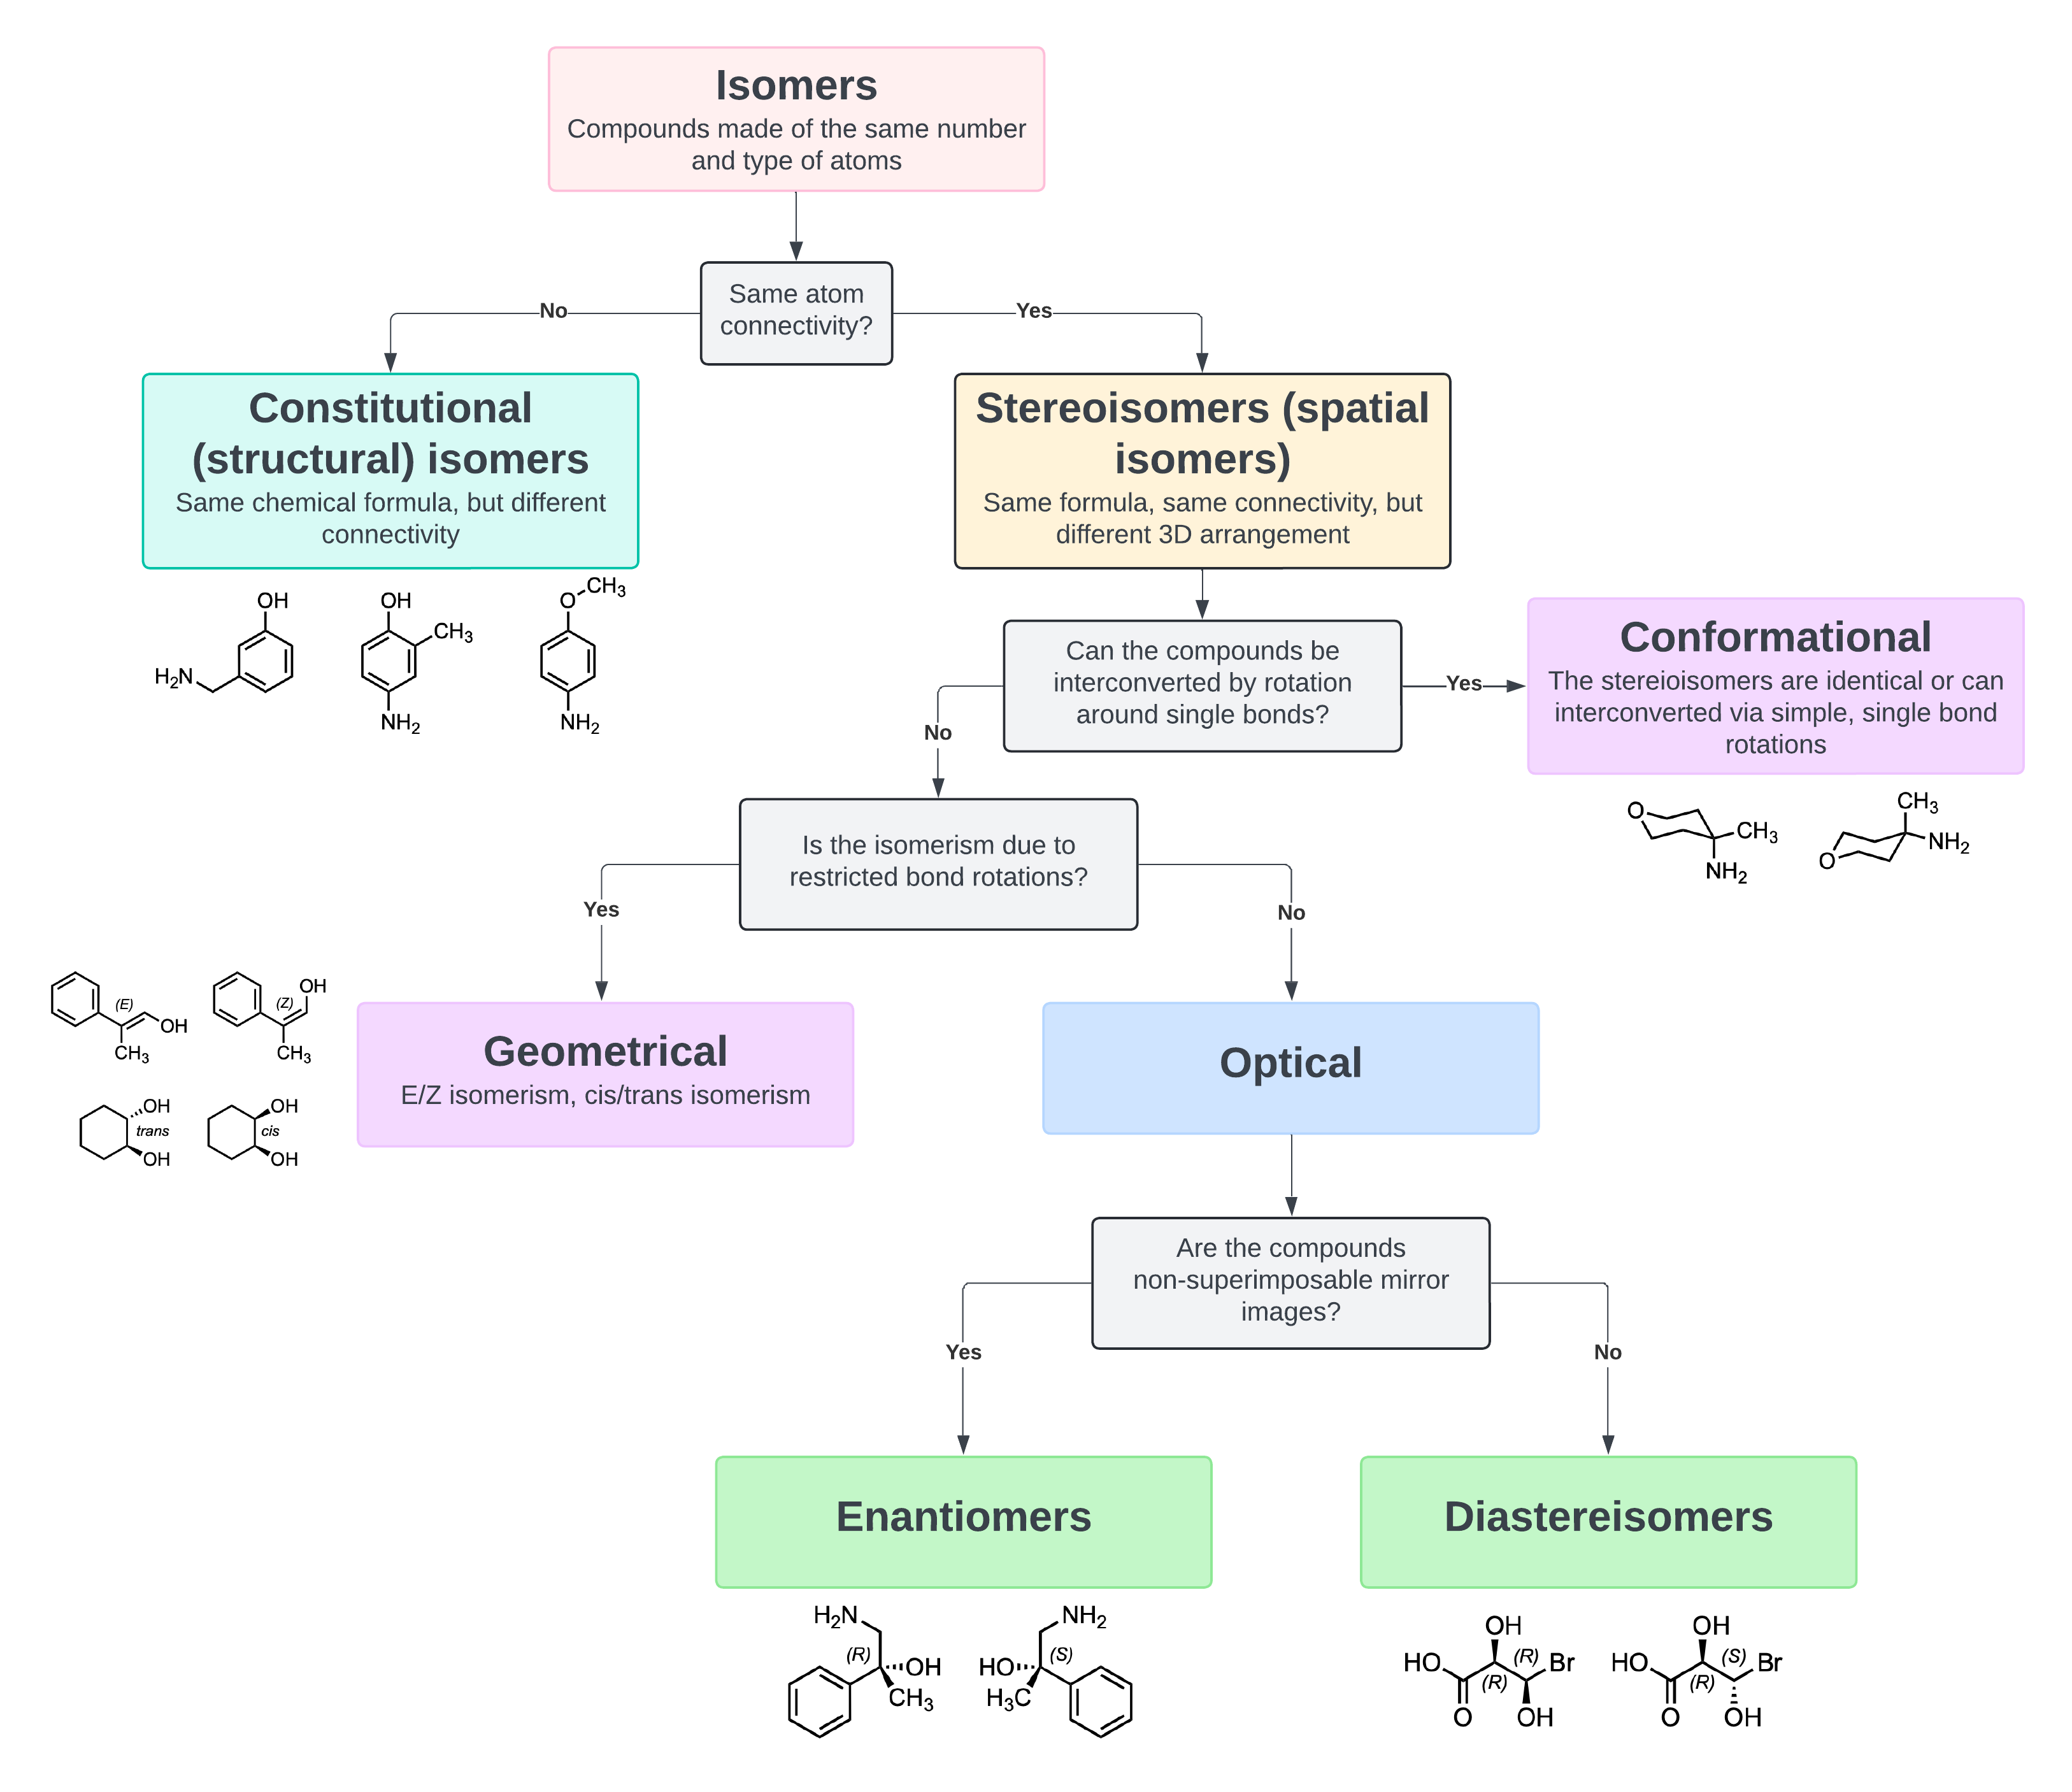

## &#x1F514;
In this notebook, we will explore different types of stereoisomerism and how the stereochemical information can be captured through molecular representations. We will also examine the impact of stereoisomers that exhibit significant activity cliffs (ACs) in the context of QSAR modeling.

In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from copy import copy
import nglview as nv

import datamol as dm
from molfeat.trans.fp import FPVecTransformer

from utils import add_3d_coord

<a id='stereo'></a>
## Types of stereoisomerisms

### Optical isomerism

Let's look at molecule Ibuprofen `CC(C)CC1=CC=C(C=C1)C(C)C(=O)O`, a common and well known compound for treating fever and mild pain.

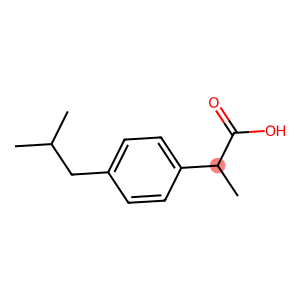

In [2]:
ibu = dm.to_mol("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O")
dm.to_image(mols=[ibu], highlight_atom=[10])

The molecule is `chiral` with one stereocenter at `atom 10`, meaning that that atom is bound to 4 different groups: a methyl, a carboxylic acid, a substituted aromatic ring, and a hydrogen atom (the latter usually not shown in 2D representations).

`Chirality` is the property of compounds that posses the same molecular formula and atom connectivity, but exist in different 3D configurations that are a `non-superimposable mirror image of each other`, similarly to your left and right hand! The different stereoisomers of chiral compounds interact differently with beams of polarized light in a phenomenon called `optical isomerism`.

Let's have a look at all the potential stereoisomers for Ibuprofen.

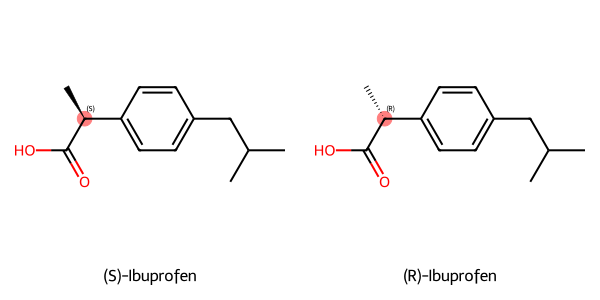

In [3]:
ibu_isomers = dm.isomers.enumerate_stereoisomers(ibu)

dm.to_image(
    ibu_isomers,
    highlight_atom=[[10], [10]],
    legends=["(S)-Ibuprofen", "(R)-Ibuprofen"],
    align=True,
)

If we 'flat' the aromatic and carboxylic acid groups in the plane of your screen, the methyl group attached to the chiral carbon atom can be pointing `up` towards you or `down` away from you (remember that C atoms have a tetrahedral disposition of the four groups bound to it; hydrogen atoms are usually omitted in 2D representations).

The molecule posseses a `single chiral center` that originates `two possible stereoisomers`. These two stereoisomers are the non-superimposable mirror image of each other thus they are commonly referred as `enantiomers`.

Let's look at the same enantiomers in 3D:

In [4]:
# view (S)-Ibuprofen in 3D
view1 = nv.show_rdkit(ibu_isomers[0])
view1

NGLWidget()

In [5]:
# view (R)-Ibuprofen in 3D
view2 = nv.show_rdkit(ibu_isomers[1])
view2

NGLWidget()

Although 2D and 3D representations often make for nice images, in cheminformatics we often represent molecules as `SMILES strings`.

The disposition of the groups on a chiral center in a SMILES string is specified using a single or double `@` symbol. In our case the chiral carbon atom would be written either `C@H` or `C@@H`.

In the case of the two enantiomers of Ibuprofen, the SMILES for each enantiomers are:

In [6]:
[dm.to_smiles(isomer) for isomer in ibu_isomers]

['CC(C)Cc1ccc([C@H](C)C(=O)O)cc1', 'CC(C)Cc1ccc([C@@H](C)C(=O)O)cc1']

Stereochemistry information can be also embedded in toher type of molecular representation other than SMILES.

For example, if we write the two stereiosmers of Ibuprofen in Inchi strings, we see that there is a small difference to identify the chirality of the carbon atom:

In [7]:
[dm.to_inchi(isomer) for isomer in ibu_isomers]

['InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)/t10-/m0/s1',
 'InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)/t10-/m1/s1']

Molecules are often converted to `rdkit.mol` objects before being transformed other advanced features vectors. 
Different stereiosmers are detected as different `rdkit.mol` object (as it should be!):

In [8]:
if not dm.same_mol(ibu_isomers[0], ibu_isomers[1]):
    print("The two molecules are not identical!")

The two molecules are not identical!


### E/Z Stereisomerism

We have briefly explored stereisomers generated by the presence of a chiral atom, but that is not the only case in which a compound can exist as different stereisomers.

Another common case of stereisomerism is the `E/Z isomerism`. This form of stereisomerism arises from the different arrangement of groups bound via a `double bond`. The most common cases are compounds containing a `C=C` double bond, but also `C=N` and `N=N` can be commonly found in nature.
The `E/Z` nomenclature derives from German for `E`ntegen (opposite) and `Z`usammen (together). In the past another nomenclature for double bond stereochemistry was utilized where E and Z were replaced by 'trans' and 'cis', respectively, but this type of notation is now deprecated and utilized for other scopes.

Due to the nature of double bonds, the four substituents (two for each carbon atom) are `all placed in the same plane` but they can point in different directions such as in the case of 1-bromo-2-chloropropene:

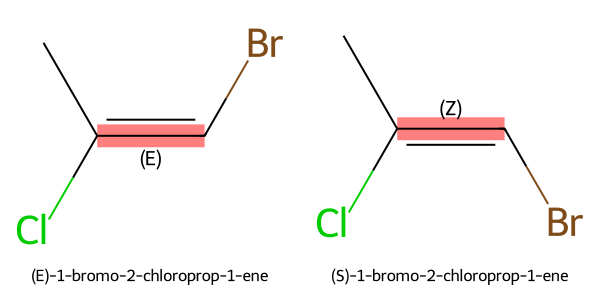

In [9]:
mol = dm.to_mol("CC(=CBr)Cl")
isomers = dm.isomers.enumerate_stereoisomers(mol)

dm.to_image(
    isomers,
    highlight_bond=[[1], [1]],
    legends=["(E)-1-bromo-2-chloroprop-1-ene", "(S)-1-bromo-2-chloroprop-1-ene"],
    align=True,
)

As before, we can see that the two possible stereisomers have the same type of atoms and the same connectivity, but quite evidently `the two halogen atoms (bromo and chloro) can either be placed on the same or the opposite 'side' of the C=C double bond`'

Similarly to chiral centers, SMILES strings have a special symbol to identify E/Z isomers: `\` or `/`:

In [10]:
[dm.to_smiles(isomer) for isomer in isomers]

['C/C(Cl)=C\\Br', 'C/C(Cl)=C/Br']

And as for two enantiomers, E and Z isomers are not the same molecule!

In [11]:
if not dm.same_mol(isomers[0], isomers[1]):
    print("The two molecules are not identical!")

The two molecules are not identical!


In [12]:
assert dm.to_inchi(ibu_isomers[0]) != dm.to_inchi(ibu_isomers[1])

We have seen molecules that contain a single chiral center or a double bond and how we define their corresponding stereisomers.
Nature is very often a bit more creative, and it is very common to encounter compounds that contains `multiple chiral atoms and/or one or more double bonds`!

Please, refer to the diagram at the beginning of this tutorial for a complete overview of all the possibilities but here a couple of examples of compounds containing multiple types of stereochemical information:

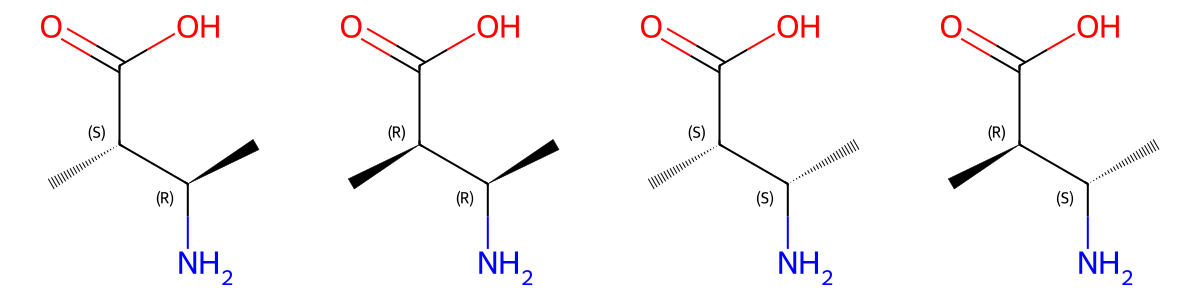

In [13]:
# Multiple stereocenters (chiral atoms) in one molecule
mols_1 = dm.to_mol("CC(C(=O)O)C(N)C")
dm.to_image(dm.isomers.enumerate_stereoisomers(mols_1), align=True)

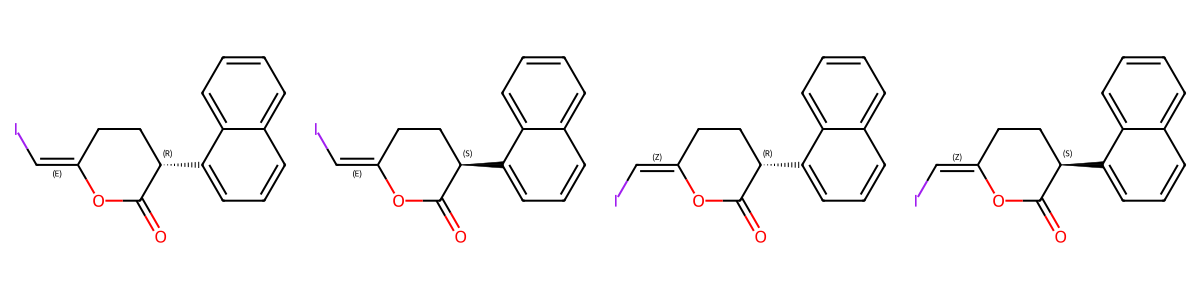

In [14]:
# Optical isomerism and E/Z isomerism in one molecule
mols_2 = dm.to_mol("O=C1OC(=CI)CCC1c1cccc2ccccc12")
dm.to_image(dm.isomers.enumerate_stereoisomers(mols_2), align=True)

### Is stereochemistry always important in QSAR?

Short answer: `YES!`
The 3D arrangement of groups in a molecule has a profound impact on how different stereisomers interact with biological targets. Remember that every single protein is nothing more that a very big molecule that contains a large amount of chiral centers, therefore `proteins and biological entities are stereisomers themselves`.
Different stereisomers (e.g., enantiomers, diastereisomers) will interact differently with their biological targets showing vastly different pharmacology, binding affinity, activity and potency, etc...

**Examples**: 
The binding site of the β2-adrenergic receptor has a specific 3D shape where (R)-albuterol fits into more precisely than the (S)-albuterol. (R)-albuterol provides more effective treatment with fewer side effects targeting β2-adrenergic receptors in comparison to (S)-albuterol.
Another example is Penicillamine, where the (S) enantiomer shows the desired antiarthritic activity, whereas the (R) enantiomer is extremely toxic!

In the `rare cases` where stereochemistry is found not to affect the biological activity of a series of compounds, the stereochemical information may be uncessessary in handling these datasets (always check before removing or ignoring stereochemistry).

Furthermore, stereochemistry may have also an impact on the `physical` (e.g., solubility, melting point) and `physiochemical` (e.g., logP, TPSA)  properties of a molecule, but not always:
    - `Enantiomers` always show the same physical and physicochemical properties;
    - `Diastereisomers` often show different physical properties but they have the same physicochemical properties.

In conclusion, it is always a good (and safe!) choice to include stereochemical information when possible, but in certain cases and for certain type of analyses it may not be necessary.

**Stereochemistry in cheminformatics**

As mentioned above, when studying the interaction between small molecules and proteins, it is very important to define `ALL` the stereochemical information of a molecule, if possible. Missing/unknown information or limitations in the chemical synthesis and purification of chemcial compounds may result in the impossibility to fully define the stereochemistry of these molecules. 

Undefined or partially defined stereochmical information is unfortunately quite common, especially in the early stages of a drug developement program, and it usually challenges efforts in QSAR modeling.

It is worth mentioning that, in early-stage drug discovery programs, where high-throughput screening (HTS) is utilized to identify hit compouds from very large libraries, the focus is more oritented towards broad activity trends rather than precise stereochemical interactions. As a result, at this stage, stereochemistry may be ignored by routinely testing racemic mixtures (mixtures containg equal amounts of the possible enantiomers), and mistures of diastereisomers.
Therefore, when utilizing models trained on such data lacking accurate stereochemical information, it is important to specify the limitations of these models, particularly regarding their applicability to other molecular databases.


## Stereisomers with activity cliff and the impact on QSAR 

Stereoisomers might exhibit activity cliffs: different stereisomers of the same molecule showing large differences in biological activity. Stereisomers associated to activity cliffs can pose challenges to QSAR modeling by creating sharp contrasts in biological activity vs chemical connectivity that are not easily captured by standard models.

Precise representation of stereochemistry and careful model design are crucial for addressing these challenges and improving the predictive accuracy and interpretability of QSAR models.

### Choice of molecular representations for stereoisomerism

Here we use featurizers(molecular transformers) from [molfeat](https://molfeat.datamol.io/) which is a hub of molecular featurizers. It supports a wide variety of out-of-the-box molecular featurizers from Fingerprints, pretrained-featurizers, deep embeddings (proteins+small mol), to molecular descriptors.

In [15]:
# generate conformers/3d coordinates
mol1_3d = dm.conformers.generate(ibu_isomers[0])
mol2_3d = dm.conformers.generate(ibu_isomers[1])
mol3_3d = dm.conformers.generate(isomers[0])
mol4_3d = dm.conformers.generate(isomers[1])

**Featurizer 1**: Let’s use the ECFP featurizer, which encodes the presence of specific substructures or features in a molecule. It is one of the most commonly used molecular representations in QSAR modeling.

In [16]:
transfomer_1 = FPVecTransformer(kind="ecfp:4", length=2042)
fp1 = transfomer_1(mol1_3d)
fp2 = transfomer_1(mol2_3d)
if np.array_equal(fp1, fp2):
    print(f"This featurizer '{transfomer_1.kind}' can't differentiate the two enantiomers!")

This featurizer 'ecfp:4' can't differentiate the two enantiomers!


In [17]:
fp3 = transfomer_1(mol3_3d)
fp4 = transfomer_1(mol4_3d)
if np.array_equal(fp3, fp4):
    print(f"This featurizer '{transfomer_1.kind}' can't differentiate the two diastereomers!")

This featurizer 'ecfp:4' can't differentiate the two diastereomers!


Now let’s explore more sophisticated featurizers that captures the 3D information of molecules.

**Featurizer 2**: 3D version of the CATS pharmacophores computed with the Pharm2D module in RDKit.

In [18]:
from molfeat.trans.base import MoleculeTransformer
from molfeat.calc.pharmacophore import Pharmacophore3D

# define transformer
transformer_2 = MoleculeTransformer(featurizer=Pharmacophore3D(factory="cats"), dtype=float)
feat1 = transformer_2(mol1_3d)
feat2 = transformer_2(mol2_3d)
if not np.array_equal(feat1, feat2):
    print(f"This featurizer '{transformer_2.featurizer.factory}' can differentiate the enantiomers!")

This featurizer 'cats' can differentiate the enantiomers!


In [19]:
feat3 = transformer_2(mol3_3d)
feat4 = transformer_2(mol4_3d)
if not np.array_equal(feat1, feat2):
    print(f"This featurizer '{transformer_2.featurizer.factory}' can differentiate the diastereomers!")

This featurizer 'cats' can differentiate the diastereomers!


Please find more details about featurizer [pharm3D-cats](https://molfeat.datamol.io/featurizers/pharm3D-cats) and explore other available featurizers on [molfeat](https://molfeat.datamol.io/) page.

###  QSAR modeling with stereoisomers exhibiting activity cliffs

In this section, we’ll take a closer look at how activity cliffs between stereoisomers can impact the predictive performance of QSAR modeling.

#### Example case: Dopamine receptor D2
The dopamine D2 receptor, like many G-protein-coupled receptors (GPCRs), exhibits stereoselectivity, meaning that stereisomers A of a small molecule may bind more effectively than stereisomer B, C,... of the same molecule. In these common cases, stereoselectivyt plays a crucial role in the pharmacological effects of drugs targeting the D2 receptor [Xiao et al. 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315423/).

Here, our **goal** is to train predictive models that perform well on both molecules that exhibit activity cliffs and those that do not.

`Note`: The dataset used in this notebooks is heterogeneous extracted from CHEMBL for demonstration purpose. 

In [20]:
# Load data set of small molecule inhibitors of dopamine receptor D2
data = pd.read_csv("data/dopamine_d2_data.csv")

In [3]:
mol_col = "MOL_smiles"  # molecule smiles strings
val_col = "CLS_pChEMBL Value"  # class label for binding affinity

mols = dm.utils.parallelized(
    fn=lambda mol: add_3d_coord(mol),
    inputs_list=data[mol_col],
    progress=True,
    n_jobs=10,
)
data["mol"] = mols

In [22]:
## `dm.conformers.generate` is a better choice for 3d coordinates and conformer generation.
## Note: this function might take longer time
# mols = dm.utils.parallelized(
#     fn=lambda mol: dm.conformers.generate(dm.to_mol(mol)),
#     inputs_list=data[mol_col],
#     progress=True,
#     n_jobs=10,
# )
# data["mol"] = mols

In [23]:
# the dataset was pre-split to train/test based on the presence of activity cliffs
data_train = data.query("split == 'train'")
data_test = data.query("split == 'test'")

In [24]:
col_AC = "AC_CLS_pChEMBL Value"  # boolean: whether the molecule show activity cliff in the dataset
data.groupby("split")[col_AC].value_counts()

split  AC_CLS_pChEMBL Value
test   False                   1361
       True                     103
train  False                   5451
       True                     102
Name: count, dtype: int64

#### Training with simple RandomForest model

To evaluate the impact of including stereochemistry information on prediction performance, we will train two QSAR models using the same machine learning algorithm and parameters. 

One model will use the `ECFP:4` featurizer, which does not capture stereochemistry, while the other will use the `pharm3D-cats` featurizer, which includes 3D stereochemical information.

In [25]:
# Define the model with specified parameters

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    criterion="gini",
    verbose=True,
    n_jobs=-1,
)

**Model 1**: `RandomForestClassifier` + `ECFP:4`

In [26]:
# Transform with featurizer which can't differe stereoisomers
transformer_1 = FPVecTransformer(kind="ecfp:4", dtype=float)
X_train = transformer_1(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values

model_1 = copy(model)
# Fit the model
model_1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

**Model 2**: `RandomForestClassifier` + `pharm3D-cats`

In [27]:
X_train = transformer_2(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values
model_2 = copy(model)
# Fit the model
model_2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

#### Compare the predictive performance on test set

In [28]:
results = {"overall": {}, "AC": {}}

#### Overall performance on entire test set

In [29]:
from utils import evaluate

results["overall"]["rf+ecfp"] = evaluate(data_test, transformer_1, model_1, mol_col="mol", val_col=val_col)

results["overall"]["rf+pharm3Dcats"] = evaluate(
    data_test, transformer_2, model_2, mol_col="mol", val_col=val_col
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:
pd.DataFrame(results["overall"])

,rf+ecfp,rf+pharm3Dcats
precision,0.807947,0.749466
recall,0.798116,0.705505
f1-score,0.802038,0.711946
support,1464.000000,1464.000000


#### Performance on stereoisomers which show activity cliff

In [31]:
results["AC"]["rf+ecfp"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_1,
    model_1,
    mol_col="mol",
    val_col=val_col,
)
results["AC"]["rf+pharm3Dcats"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_2,
    model_2,
    mol_col="mol",
    val_col=val_col,
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
pd.DataFrame(results["AC"])

,rf+ecfp,rf+pharm3Dcats
precision,0.290427,0.480769
recall,0.292642,0.481887
f1-score,0.290192,0.475751
support,103.000000,103.000000


QSAR modeling involving stereisomers and activity cliffs is always challenging.
The results above demonstrate that, while the model trained with `pharm3D-cats` underperformed in overall prediction accuracy, it significantly outperformed when predicting the activity of stereoisomers with activity cliffs. This highlights the importance of using proper molecular representations that effectively capture stereochemical information.

When applying predictive models to a different set of molecules, it is crucial to carefully select the appropriate model for deployment. In this example, if we aim to make predictions on a lead series of molecules that contains stereochemical features that are essential for binding to the D2 target, the model `rf+pharm3Dcats` should be chosen. Conversely, for datasets consisting of non-chiral molecules or compounds that do not contain any stereogenic feature, the `rf+ecfp` model would be sufficient.

## Final notes

Careful data curation and auditing is essential to determine whether the observed bioactivity of a series of compounds is highly dependent on their stereochemistry or not.
`Auroris` simplifies and streamlines this process by providing the [StereoIsomerACDetection](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L61) module and the corresponding  [detect_stereoisomer_activity_cliff](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L15) function to easily assess this instances. 

For guidance on how to combine different Auroris modules for small molecule dataset curation, please checkout this [tutorial](https://polaris-hub.github.io/auroris/stable/tutorials/getting_started.html).

The end.